# Preprocessing Images

    1. Define and test function to split images that are collaged into `before` and `after` segments
    

#### Overview

The images in the dataset are available at reddit.com/r/progresspics. This subreddit thread has been active for over 10 years, and has been a place where community members share in the pride they take in transforming their image. Members often share strength-gain and weight-loss testimonies. Due to the social norms of this community, the posts often come in a reliable format, though there have been several norms over the years. The two most common are:

* A before and after picture as a collage, appearing in the following ways:
    * Members embed each image in a frame/border within a larger outer border
    * Images are seperated by a single vertical line
    * Images are simply joined side by side in one file.

* A gallery of images in chronological order.

#### Objective

To train a generative computer vision model to imitate the transformations shared from before to after.

This notebook develops a method to split image collages regardless of their format into before and after data that is ready for model input.

#### Computer Vision Algorithm

###### For each image:

1. Read the image into a 2-D array of size height x width, containing greyscale values for each pixel.
2. Take a sliding window of size height x 2px (two adjacent columns of the image)
    * Begin the window 1/5th into the image and finish at 4/5th to reduce false positives.
        * *(If the uploader's goal was to show a transformation from one type of physical feature to the same across time, they are most likely to need comparable amount of space to show, for instance, a body and a body, or a face and a face, etc, and split points are most likely to be in the center.)*
3. Attempt to detect a frame
    * Take a sliding window spanning 2 adjacent columns of the image (height x 2 pixels)
    * Crop out the top 1/15th and bottom 1/15th of the 2 columns to allow for a single vertical line or outer frame
    * If the pixels in the window contain one unique value, a border is detected
    * Define the split point at this window
4. Else, calculate the mean squared error (MSE; the mean of the squared deviations from adjacent pixels from column 1 to column 2), including the top and bottom portions
    * Define the split point as the window with the largest MSE

In [33]:
import cv2
import os
import shutil as sh
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont, ImageCms
import dask.dataframe as dd
from dask.multiprocessing import get
from dask import delayed, compute
from dask.diagnostics import ProgressBar
import subprocess
from timeit import timeit
os.chdir('/Users/iandouglas/Projects/Repos/generative-ai/')

Define a function to display original, before, and after images.

In [14]:
def display_split_images(original, before, after):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].set_yticks([i * original.shape[0] // 15 for i in range(16)])  # Set 16 y-axis ticks
    axes[0].set_xticks([])

    # Plot the "before" image
    axes[1].imshow(before)
    axes[1].set_title('Before')
    axes[1].set_yticks([i * before.shape[0] // 15 for i in range(16)])  # Set 16 y-axis ticks
    axes[1].set_xticks([])

    # Plot the "after" image
    axes[2].imshow(after)
    axes[2].set_title('After')
    axes[2].set_yticks([i * after.shape[0] // 15 for i in range(16)])  # Set 16 y-axis ticks
    axes[2].set_xticks([])

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [31]:
def find_best_line_and_split(file_path, before_dir=None, after_dir=None, save=True, return_mse_window=False):
    # Read in the image (get it's filename for saving out segments into before and after)
    filename = file_path.split('/')[-1]
    id_ = filename.split('.')[0]
    
    # Read the image in grayscale
    img_gray = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    if not img_gray is None: # checking the image read in at all
        window_width = 2 # Window size = 2px; it should be as small as possible

        # Define the range for the window search (1/5 to 4/5 from the left)
        start_col = int(img_gray.shape[1] / 5)
        end_col = int(4 * img_gray.shape[1] / 5)

        # Initialize variables to store the best split point information
        best_line_col1 = start_col
        best_line_col2 = start_col + window_width
        max_mse = 0 # start at no difference between columns

        # Iterate through columns within the specified range
        for col in range(start_col, end_col - window_width):
            # Extract two columns in the window
            window_cols = img_gray[:, col:col+window_width]

            # 1. Look for a frame.
            
            # Drop the very top in case the horizontal portion
            # of the frame is a different color than the vertical portion of the frame
            # 13/15ths of the image having exactly the same pigment is still significantly indicative of a frame
            crop = int(window_cols.shape[0] / 15) # drop the top and bottom pixels
            window_crop = window_cols[crop:-crop, :]

            # If a frame is found:
            if len(np.unique(window_crop)) == 1:
                best_line_col1 = col
                best_line_col2 = col + window_width
                max_mse = 0
                break  # Stop the window search

            # 2. Look for highest contrast between columns
            
            # Calculate MSE between column vectors in the window
            mse = np.mean(np.square(np.diff(window_cols)))

            # Update best split point if current mse is greatest
            if mse > max_mse:
                max_mse = mse
                best_line_col1 = col
                best_line_col2 = col + window_width
        
        # (optional) Return a window's location and the mse if requested.
        if return_mse_window:
            return pd.DataFrame({'normed_col': [best_line_col1/img_gray.shape[1]], 'mse': [max_mse]})
        
        # 3. Split the image and save or plot
        
        # Read the original color image to split it (don't save greyscale!)
        img_color = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_RGB2BGR)

        # Crop the color image into "before" and "after" at the best split point
        before_img = img_color[:, :best_line_col1, :]
        after_img = img_color[:, best_line_col2:, :]

        # Save the cropped color images with the original filename
        if save:
            out_before = f"{before_dir}/{filename}"
            out_after = f"{after_dir}/{filename}"
            cv2.imwrite(out_before, before_img)
            cv2.imwrite(out_after, after_img)
            # Return the filename for logging
            return filename
        else:
            display_split_images(img_color, before_img, after_img)

Sample results

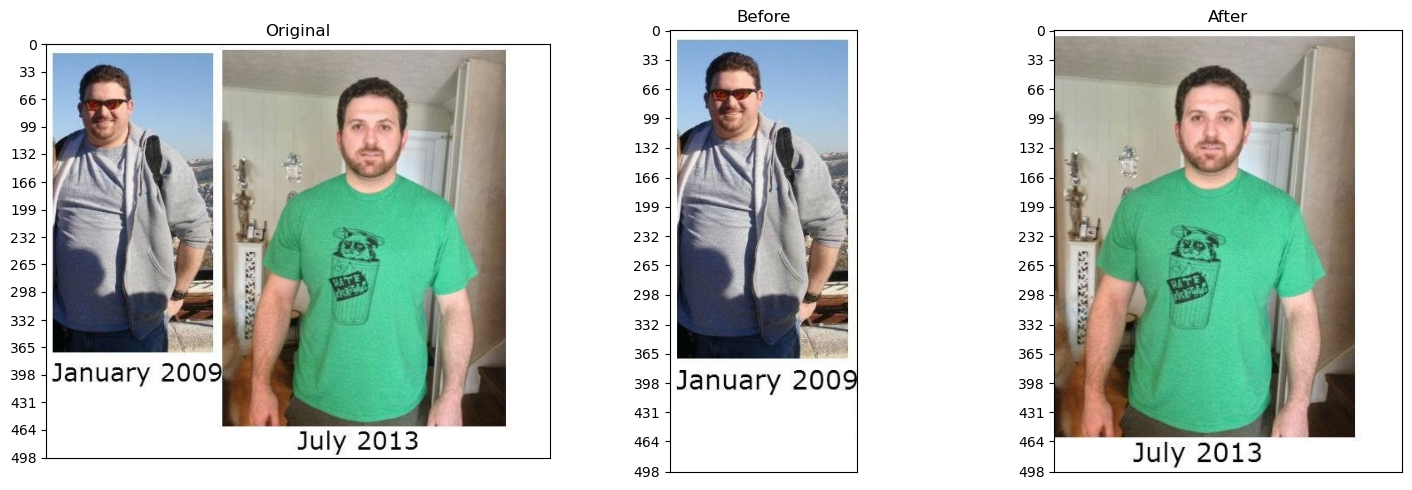

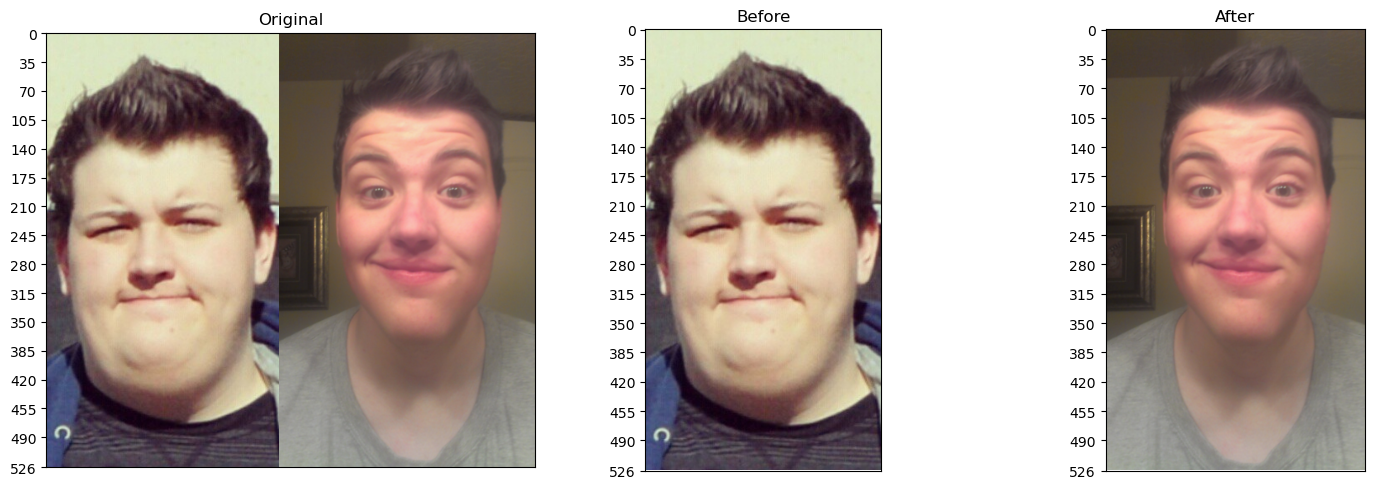

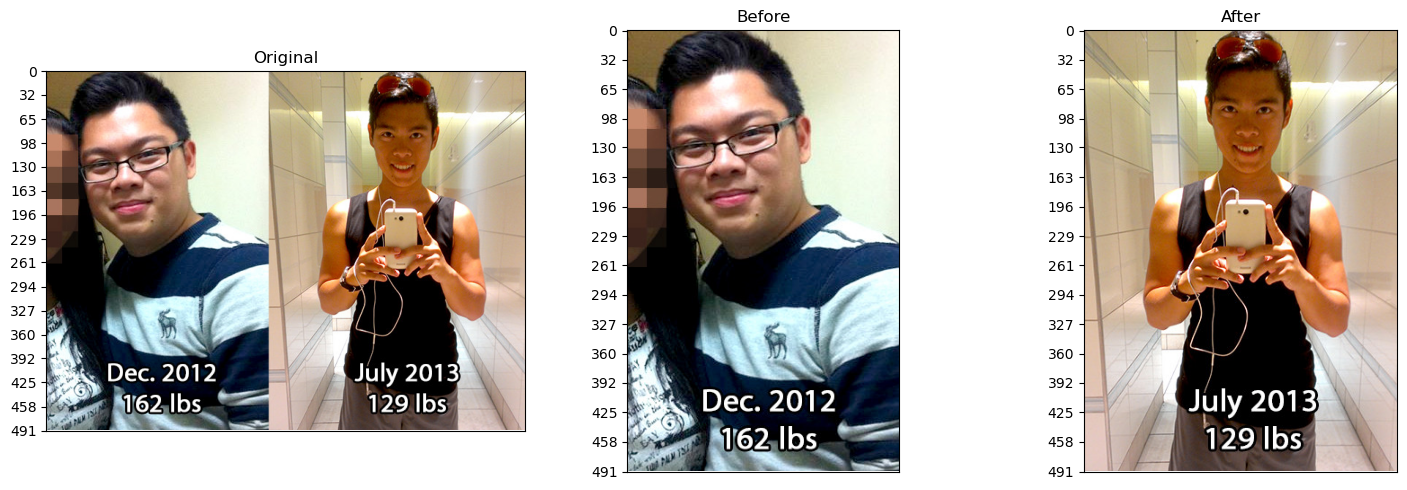

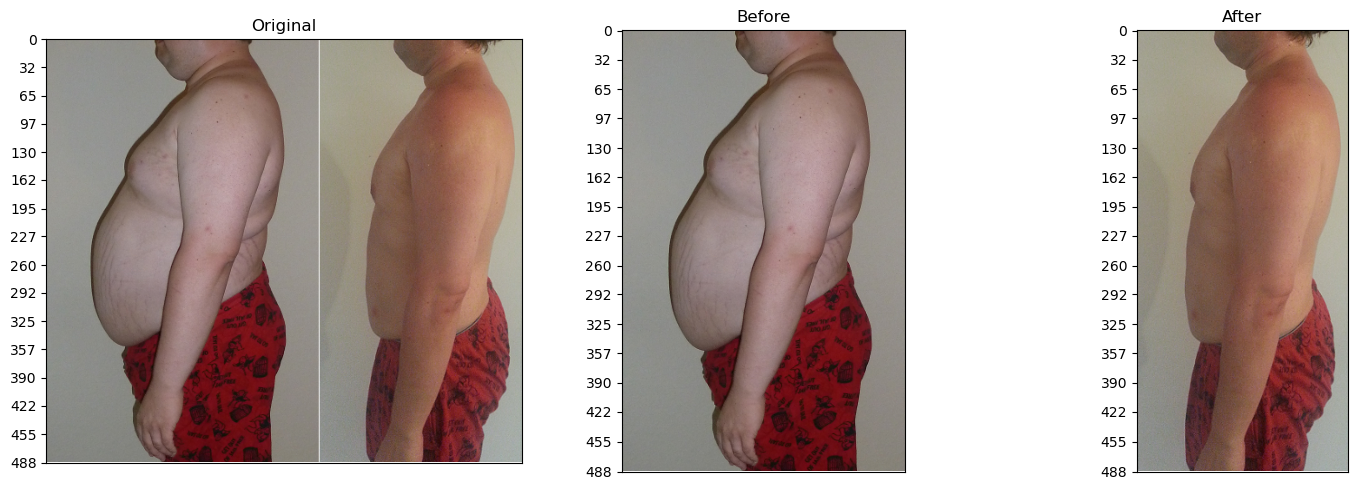

In [11]:
test_images = [
    'data/image_extraction/progresspics/url/1hwfpy.jpg',
    'data/image_extraction/progresspics/url/1i2s37.jpg',
    'data/image_extraction/progresspics/url/1i6swt.jpg',
    'data/image_extraction/progresspics/url/1mm5rp.jpg',
]
for i in test_images:
    find_best_line_and_split(file_path = i, save=False)

The results demonstrate that the method is robust to each type of collage.

#### Evaluate Performance

In [32]:
data_dir = 'data/image_extraction/progresspics/url_clean/'
test_images = os.listdir(data_dir)[0:1000]
test_images = [f"{data_dir}/{jpg}" for jpg in test_images if jpg.endswith('jpg')]

results = []
def eval_split(images = test_images, results = results):
    for i in images:
        results.append(find_best_line_and_split(file_path = i, save=False, return_mse_window=True))

execution_time = timeit(eval_split, number=1)
print(f'Time to compute {len(test_images)} images: {np.round(execution_time, 2)}s')

Time to compute 1000 images: 82.37s


## Evaluate Dataset Distributions

1. The results can be used to learn the location at which split points are most likely to occur

2. And what is MSE at split points, relative to between adjacent columns in general

##### Location of split points

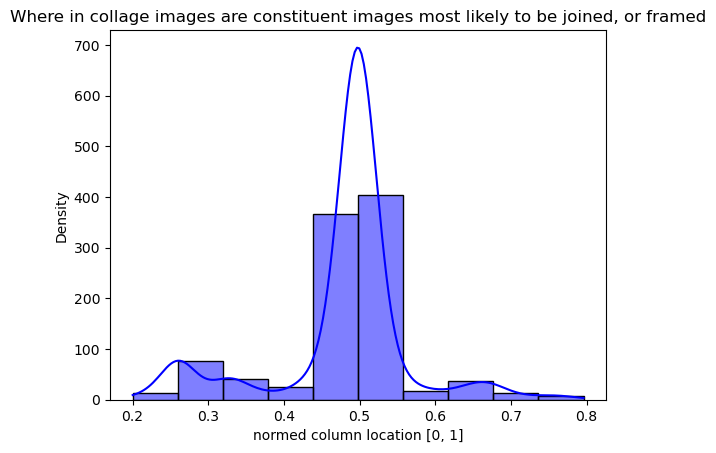

In [38]:
# Get the results from each iteration:
df = pd.concat(results)

# Plot the distribution of split points
sns.histplot(df['normed_col'], bins=10, kde=True, color='blue')
plt.title('Where in collage images are constituent images most likely to be joined, or framed')
plt.xlabel('normed column location [0, 1]')
plt.ylabel('Density')
plt.show()


In [ ]:
population_mse = []
for i in test_images:
    img_gray = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    if not img_gray is None:
        for col in range(0, img_gray.shape[1] - 2):
            window = img_gray[:, col:col+2]
            population_mse.append(np.mean(np.square(np.diff(window))))

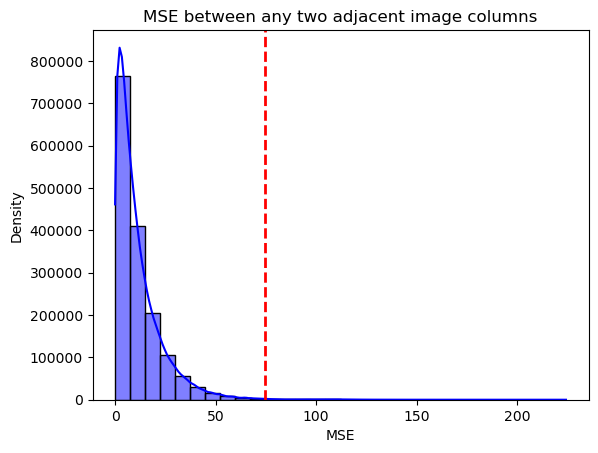

In [42]:
# Plot the distribution of split points
sns.histplot(population_mse, bins=30, kde=True, color='blue')
plt.axvline(df['mse'].mean(), color='red', linestyle='dashed', linewidth=2, label='Split point MSE')
plt.title('MSE between any two adjacent image columns')
plt.xlabel('MSE')
plt.ylabel('Density')
plt.show()